In [1]:
import findspark
findspark.init()
import pyspark, os, csv
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, max, min, substring_index, avg, expr, concat, lit
from pyspark.sql.window import Window
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap, Normalize
from matplotlib import colormaps
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
#Create Spark Session
spark = SparkSession.builder.appName("VaccinebyState").getOrCreate()

In [3]:
#directories paths
root_dir = "vaccine_region"
data_dir = "data"

state_dir = f"{root_dir}/state_vac_by_dimension"
age_dir = f"{state_dir}/state_Age"
race_dir = f"{state_dir}/state_Race and Ethnicity"
smaps_dir = f"{state_dir}/age_maps"
rmaps_dir = f"{state_dir}/re_maps"

county_dir = f"{root_dir}/county_vac_by_dimension"
cbyc_dir = f"{county_dir}/county_by_county"
cmaps_dir = f"{county_dir}/c_maps"

In [68]:
#gather all state data
fpaths = []
if not os.listdir(state_dir):
    df = spark.read.csv(f"{data_dir}/Influenza_Vaccination_Coverage_for_All_Ages__6__Months_.csv", header=True, inferSchema=True)
    df = df.filter(df["Geography Type"] != "Counties")
    df = df.filter(df["Vaccine"] == "Seasonal Influenza")
    df = df.withColumn("Date", concat(col("Month"), lit("/"), col("Season/Survey Year")))
    dtypes = ["Age", "Race and Ethnicity"]
    
    for d in dtypes:
        ddf = df.filter(df["Dimension Type"] == d)
        ddf = ddf.select("Geography", "FIPS", "Date", "Dimension", "Estimate (%)")
        ddf = ddf.toPandas()
        
        folder_path = f"{state_dir}/state_{d}" 
        fpaths.append(folder_path)
        ddf.to_csv(f"{folder_path}.csv", header=True, index=False)
        if not os.path.exists(folder_path):
            try:
                # If it doesn't exist, create the folder
                os.makedirs(folder_path)
                print(f"Folder '{folder_path}' created successfully.")
            except OSError as e:
                print(f"Failed to create folder '{folder_path}': {e}")
    
df = spark.read.csv(f"{state_dir}/state_Age.csv", header=True, inferSchema=True)
df.show()


+-----------+----+----------+--------------------+------------+
|  Geography|FIPS|      Date|           Dimension|Estimate (%)|
+-----------+----+----------+--------------------+------------+
|Connecticut|   9| 4/2020-21|18-49 Years at Hi...|        49.0|
|Connecticut|   9| 5/2020-21|18-49 Years at Hi...|        52.8|
|Connecticut|   9| 7/2021-22|18-49 Years at Hi...|        NR †|
|Connecticut|   9| 8/2021-22|18-49 Years at Hi...|        NR †|
|Connecticut|   9| 7/2012-13|         18-49 Years|         0.1|
|Connecticut|   9| 5/2011-12|         18-49 Years|        32.2|
|Connecticut|   9| 8/2012-13|         18-49 Years|        NR †|
|Connecticut|   9| 9/2012-13|         18-49 Years|         3.7|
|Connecticut|   9|10/2012-13|         18-49 Years|        15.3|
|Connecticut|   9|11/2012-13|         18-49 Years|        23.5|
|Connecticut|   9| 4/2018-19|18-64 Years not a...|        41.9|
|Connecticut|   9| 5/2018-19|18-64 Years not a...|        43.4|
|Connecticut|   9| 7/2019-20|18-64 Years

In [94]:
#create map folders
if not os.path.exists(smaps_dir):
            try:
                # If it doesn't exist, create the folder
                os.makedirs(smaps_dir)
                print(f"Folder '{smaps_dir}' created successfully.")
            except OSError as e:
                print(f"Failed to create folder '{smaps_dir}': {e}")

if not os.path.exists(rmaps_dir):
            try:
                # If it doesn't exist, create the folder
                os.makedirs(rmaps_dir)
                print(f"Folder '{rmaps_dir}' created successfully.")
            except OSError as e:
                print(f"Failed to create folder '{rmaps_dir}': {e}")
if not fpaths:
    fpaths = [age_dir, race_dir]

In [95]:
#separate state data by dimension
if not os.listdir(age_dir):
    csv_files = [filename for filename in os.listdir(state_dir) if filename.endswith(".csv")]
    c = 0
    for csv_file in csv_files: 
        csv_file_path = os.path.join(state_dir, csv_file)
        # Read the CSV file into a DataFrame
        df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

        group_column = "Dimension"
        distinct_dimensions = [str(row[group_column]) for row in df.select(group_column).distinct().collect()]

        # Group by the column and write each group to a separate file
        for di in distinct_dimensions:
#             a = 0
            ddf = df.filter(col(group_column) == di)
            date_column = "Date"
            distinct_dates = [str(row[date_column]) for row in df.select(date_column).distinct().collect()]
            for da in distinct_dates:
                dff = ddf.filter(col(date_column) == da)
                da = da.replace("/", "_of_")
                if not dff.isEmpty():
                    output_path = f"{fpaths[c]}/{di}_{da}.csv"
                    pandas_df = dff.toPandas()
                    pandas_df.to_csv(output_path, header=True, index=False)
#                 a=a+1
        c=c+1

In [64]:
#Generate Heatmaps for Age Ranges Per State
if os.listdir(age_dir):
    state_map = gpd.read_file(f"data/states/cb_2018_us_state_500k.shp")
    csv_files = [filename for filename in os.listdir(age_dir) if filename.endswith(".csv")]
    for csv_file in csv_files:
        csv_file_path = os.path.join(age_dir, csv_file)
        df = pd.read_csv(csv_file_path)
        df["Estimate (%)"] = df["Estimate (%)"].replace(to_replace=".*NR.*", value="-1", regex=True)
        titled_column = "Date"
        titled_value = df[titled_column].iloc[0]
        titled_value = titled_value.replace("/", " of ")
        title_column = "Dimension"
        title_value = df[title_column].iloc[0]
        output_file = os.path.join(smaps_dir, f"Month {titled_value} for Age Range {title_value}" + ".png")
        if os.path.isfile(output_file):
            continue

        # Calculate the maximum and minimum values in the "Total_ILI" column
        max_value = df["Estimate (%)"].max()
        min_value = df["Estimate (%)"].min()

        # Define a custom colormap with red for values equal to -1
        cmap = colormaps["Blues"]
        cmap_list = [cmap(i) for i in range(cmap.N)]
        cmap_list[0] = (1.0, 0.0, 0.0, 1.0)  # Set the first color to red
        custom_cmap = ListedColormap(cmap_list)

        # Merge files
        state_map["STATEFP"] = state_map["STATEFP"].astype(int)
        mapf = "STATEFP"
        statf = "FIPS"
        map_and_stats = state_map.merge(df, left_on=mapf, right_on=statf)

        # Plot map with the custom colormap
        fig, ax = plt.subplots(figsize=(12, 12))
        map_and_stats.plot(column="Estimate (%)", cmap=custom_cmap, linewidth=0.4, edgecolor=".4", ax=ax)

        # Set up colorbar
        cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='vertical', fraction=0.03, pad=0.1, aspect=10)
        cbar.set_label('Estimate (%)')

        # Set the title and adjust the map limits
        ax.set_xlim([-190, -50])
        ax.set_ylim([10, 80])
        plt.title(f"Seasonal Influenza Vaccine during Month {titled_value} for Age Range: {title_value}")
        
        # Create a customizable legend
        legend_labels = ['Incomplete Sample (NR)', 'Est % of who got vaccinated']
        legend_colors = ['red', 'blue']
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=col, markersize=10) for col in legend_colors]
        ax.legend(legend_elements, legend_labels, loc='upper left', title='Legend Title')

        # Save the map as an image file in the maps directory
        plt.savefig(output_file, dpi=300)

        # Close the figure to release memory
        plt.close(fig)

In [119]:
#Generate Heatmaps for Race/Ethnicity per State
if os.listdir(race_dir):
    state_map = gpd.read_file(f"data/states/cb_2018_us_state_500k.shp")
    csv_files = [filename for filename in os.listdir(race_dir) if filename.endswith(".csv")]
    for csv_file in csv_files:
        csv_file_path = os.path.join(race_dir, csv_file)
        df = pd.read_csv(csv_file_path)
        df["Estimate (%)"] = df["Estimate (%)"].replace(to_replace=".*NR.*", value="-1", regex=True)

        # Calculate the maximum and minimum values in the "Total_ILI" column
        max_value = df["Estimate (%)"].max()
        min_value = df["Estimate (%)"].min()

        # Define a custom colormap with red for values equal to -1
        cmap = colormaps["Blues"]
        cmap_list = [cmap(i) for i in range(cmap.N)]
        cmap_list[0] = (1.0, 0.0, 0.0, 1.0)  # Set the first color to red
        custom_cmap = ListedColormap(cmap_list)

        # Merge files
        state_map["STATEFP"] = state_map["STATEFP"].astype(int)
        mapf = "STATEFP"
        statf = "FIPS"
        map_and_stats = state_map.merge(df, left_on=mapf, right_on=statf)

        # Plot map with the custom colormap
        fig, ax = plt.subplots(figsize=(12, 12))
        map_and_stats.plot(column="Estimate (%)", cmap=custom_cmap, linewidth=0.4, edgecolor=".4", ax=ax)

        # Set up colorbar
        cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='vertical', fraction=0.03, pad=0.1, aspect=10)
        cbar.set_label('Estimate (%)')

        # Set the title and adjust the map limits
        ax.set_xlim([-190, -50])
        ax.set_ylim([10, 80])
        titled_column = "Date"
        titled_value = df[titled_column].iloc[0]
        titled_value = titled_value.replace("/", " of ")
        title_column = "Dimension"
        title_value = df[title_column].iloc[0]
        plt.title(f"Seasonal Influenza Vaccine during Month {titled_value} for: {title_value}")
        
        # Create a customizable legend
        legend_labels = ['Incomplete Sample (NR)', 'Est % of who got vaccinated']
        legend_colors = ['red', 'blue']
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=col, markersize=10) for col in legend_colors]
        ax.legend(legend_elements, legend_labels, loc='upper left', title='Legend Title')

        # Save the map as an image file in the maps directory
        output_file = os.path.join(rmaps_dir, os.path.splitext(csv_file)[0] + ".png")
        plt.savefig(output_file, dpi=300)

        # Close the figure to release memory
        plt.close(fig)

In [153]:
#gather all county data
if not os.listdir(county_dir):
    df = spark.read.csv(f"{data_dir}/Influenza_Vaccination_Coverage_for_All_Ages__6__Months_.csv", header=True, inferSchema=True)
    df = df.filter(df["Geography Type"] == "Counties")
    df = df.filter(df["Vaccine"] == "Seasonal Influenza")
    df = df.withColumn("Date", concat(col("Month"), lit("_of_"), col("Season/Survey Year")))
    
    df = df.select("Geography", "FIPS", "Date", "Dimension", "Estimate (%)", "95% CI (%)")
    df = df.withColumnRenamed("95% CI (%)", "Range")
    group_column = "Date"
    distinct_dates = [str(row[group_column]) for row in df.select(group_column).distinct().collect()]
    
    folder_path = cbyc_dir
    if not os.path.exists(folder_path):
        try:
            # If it doesn't exist, create the folder
            os.makedirs(folder_path)
            print(f"Folder '{folder_path}' created successfully.")
        except OSError as e:
            print(f"Failed to create folder '{folder_path}': {e}")
    
    for d in distinct_dates:
        ddf = df.filter(col(group_column) == d)
        ddf = ddf.filter(col("Dimension").like("%Years%"))
        
        ddf = ddf.withColumn(
            'Difference',
            (expr("float(substr(Range, instr(Range, ' to ') + 4, 10))") -
             expr("float(substr(Range, 1, instr(Range, ' to ') - 2))"))
        )
        window_spec = Window.partitionBy('Geography')
        ddf = ddf.withColumn('min_diff', min('Difference').over(window_spec)) \
            .filter(col('Difference') == col('min_diff')) \
            .drop('min_diff')
        ddf = ddf.toPandas()
        ddf.to_csv(f"{folder_path}/county_{d}.csv", header=True, index=False)
print("done")

Folder 'vaccine_region/county_vac_by_dimension/county_by_county' created successfully.
done


In [4]:
#create map folders
if not os.path.exists(cmaps_dir):
            try:
                # If it doesn't exist, create the folder
                os.makedirs(cmaps_dir)
                print(f"Folder '{cmaps_dir}' created successfully.")
            except OSError as e:
                print(f"Failed to create folder '{cmaps_dir}': {e}")


Folder 'vaccine_region/county_vac_by_dimension/c_maps' created successfully.


In [67]:
#Generate Heatmaps for Age Ranges Per counties
if os.listdir(cbyc_dir):
    county_map = gpd.read_file(f"data/us_counties/UScounties.shp")
    csv_files = [filename for filename in os.listdir(cbyc_dir) if filename.endswith(".csv")]
    for csv_file in csv_files:
        csv_file_path = os.path.join(cbyc_dir, csv_file)
        df = pd.read_csv(csv_file_path)
        df["Estimate (%)"] = df["Estimate (%)"].replace(to_replace=".*NR.*", value="-1", regex=True)
        
        # Calculate the maximum and minimum values in the "Total_ILI" column
        max_value = df["Estimate (%)"].max()
        min_value = df["Estimate (%)"].min()

        # Define a custom colormap with red for values equal to -1
        cmap = colormaps["Blues"]
        cmap_list = [cmap(i) for i in range(cmap.N)]
        cmap_list[0] = (1.0, 0.0, 0.0, 1.0)  # Set the first color to red
        custom_cmap = ListedColormap(cmap_list)

        # Merge files
        
        county_map["FIPS"] = county_map["FIPS"].astype(int)
        mapf = "FIPS"
        statf = "FIPS"
        map_and_stats = county_map.merge(df, on="FIPS", how="left")
        # Plot map with the custom colormap
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])

        county_map.plot( ax=ax,facecolor='gray' )
        map_and_stats.plot(column="Estimate (%)", cmap=custom_cmap, linewidth=0.4, edgecolor=".4", ax=ax)

        # Set up colorbar
        cbar = fig.colorbar(ax.collections[1], ax=ax, orientation='vertical', fraction=0.03, pad=0.1, aspect=10)
        cbar.set_label('Estimate (%)')

        # Set the title and adjust the map limits
        titled_column = "Date"
        titled_value = df[titled_column].iloc[0]
        titled_value = titled_value.replace("_of_", " of ")
        title_column = "Dimension"
        title_value = df[title_column].iloc[0]
        plt.title(f"Seasonal Influenza Vaccine during Month {titled_value} for Age Range: {title_value}")
        
        # Create a customizable legend
        legend_labels = ['Incomplete Sample (NR)', 'Est % of who got vaccinated', 'No data']
        legend_colors = ['red', 'blue', 'gray']
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=col, markersize=10) for col in legend_colors]
        ax.legend(legend_elements, legend_labels, loc='upper left', title='Legend Title')

        # Save the map as an image file in the maps directory
        output_file = os.path.join(cmaps_dir, f"Month {titled_value} for Age Range {title_value}" + ".png")
        plt.savefig(output_file, dpi=300)

        # Close the figure to release memory
        plt.close(fig)

Heatmap of vaccine >18 in calif

In [64]:
#Generate Heatmaps for Age Ranges Per county in california
if os.listdir(cbyc_dir):
    # county_map = gpd.read_file(f"data/us_counties/UScounties.shp")
    county_map = gpd.read_file(f"data/CA_Counties/CA_Counties_TIGER2016.shp")
    csv_files = [filename for filename in os.listdir(cbyc_dir) if filename.endswith(".csv")]
    for csv_file in csv_files:
        csv_file_path = os.path.join(cbyc_dir, csv_file)
        df = pd.read_csv(csv_file_path)
        df["Estimate (%)"] = df["Estimate (%)"].replace(to_replace=".*NR.*", value="-1", regex=True)
        
        county_map["GEOID"] = county_map["GEOID"].astype(int)
        mapf = "FIPS"
        statf = "FIPS"
        map_and_stats = county_map.merge(df, left_on="GEOID", right_on="FIPS" )

        # Calculate the maximum and minimum values in the "Total_ILI" column
        max_value = map_and_stats["Estimate (%)"].max()
        min_value = map_and_stats["Estimate (%)"].min()

        # Define a custom colormap with red for values equal to -1
        cmap = colormaps["Blues"]
        cmap_list = [cmap(i) for i in range(cmap.N)]
        cmap_list[0] = (1.0, 0.0, 0.0, 1.0)  # Set the first color to red
        custom_cmap = ListedColormap(cmap_list)

        # Merge files
        # print( df['FIPS' == 6037] )
        
        # county_map["FIPS"] = county_map["FIPS"].astype(int)
        # county_map["GEOID"] = county_map["GEOID"].astype(int)
        # mapf = "FIPS"
        # statf = "FIPS"
        # map_and_stats = county_map.merge(df, left_on="GEOID", right_on="FIPS" )
        # print( map_and_stats )
        # map_and_stats = county_map.merge(df, on="FIPS", how="left")
        # print( map_and_stats )
        # Plot map with the custom colormap
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])

        # map_and_stats.plot(column="Estimate (%)", cmap=custom_cmap, linewidth=0.4, edgecolor=".4", ax=ax)
        county_map.plot( ax=ax, facecolor='gray' )
        map_and_stats.plot( ax=ax, column="Estimate (%)", cmap=custom_cmap, linewidth=0.4, edgecolor=".4")

        # Set up colorbar
        cbar = fig.colorbar(ax.collections[1], ax=ax, orientation='vertical', fraction=0.03, pad=0.1, aspect=10)
        cbar.set_label('Estimate (%)')

        # Set the title and adjust the map limits
        titled_column = "Date"
        titled_value = df[titled_column].iloc[0]
        titled_value = titled_value.replace("_of_", " of ")
        title_column = "Dimension"
        title_value = df[title_column].iloc[0]
        plt.title(f"Seasonal Influenza Vaccine during Month {titled_value} for Age Range: {title_value}")
        
        # Create a customizable legend
        legend_labels = ['Incomplete Sample (NR)', 'Est % of who got vaccinated', 'No data']
        legend_colors = ['red', 'blue', 'gray']
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=col, markersize=10) for col in legend_colors]
        ax.legend(legend_elements, legend_labels, loc='upper left', title='Legend Title')

        # Save the map as an image file in the maps directory
        output_file = os.path.join(cmaps_dir, f"Month {titled_value} for Age Range {title_value}" + ".png")
        plt.savefig(output_file, dpi=300)

        # Close the figure to release memory
        plt.close(fig)

In [6]:
spred_dir = f"{state_dir}/spred"
cpred_dir = f"{county_dir}/cpred"
spmap_dir = f"{state_dir}/sp_maps"
cpmap_dir = f"{county_dir}/cp_maps"
if not os.path.exists(spred_dir):
    os.makedirs(spred_dir)

if not os.path.exists(spmap_dir):
    os.makedirs(spmap_dir)

if not os.path.exists(cpred_dir):
    os.makedirs(cpred_dir)

if not os.path.exists(cpmap_dir):
    os.makedirs(cpmap_dir)

C:\Users\jourd\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean Squared Error (MSE): 377.4581457310976
Root Mean Squared Error (RMSE): 19.428282109623012


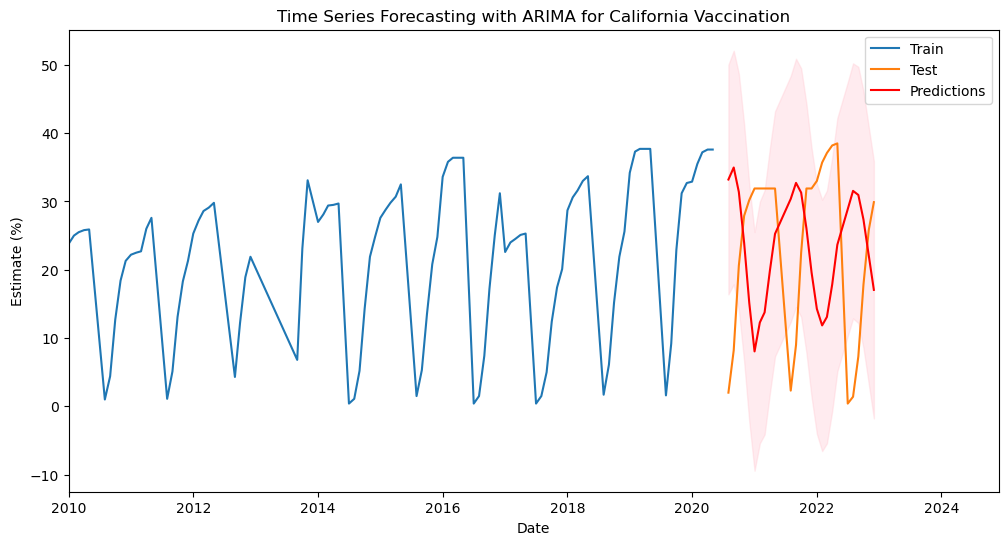

In [36]:
unique = "California"
df = spark.read.csv(f"{state_dir}/state_Age.csv", header=True, inferSchema=True)
df = df.withColumn("Date", expr("substring_index(Date, '-', 1)"))
df = df.filter(df["Dimension"] == "18-49 Years")
df = df.filter(~col("Estimate (%)").contains("NR"))
ddf = df.filter(df["Geography"] == unique)
dd = ddf.toPandas()
dd['Date'] = pd.to_datetime( dd['Date'], format='%m/%Y')
dd.sort_values('Date', inplace=True)
dd['Estimate (%)'] = dd['Estimate (%)'].astype(float)
dd.set_index('Date', inplace=True)

# Split the data into training and testing sets
train_size = int(len(dd) * 0.8)
train_data, test_data = dd[:train_size], dd[train_size:]

# Perform auto ARIMA model selection
model = auto_arima(dd['Estimate (%)'], seasonal=True, m=12)
model.fit(dd['Estimate (%)'])
forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data['Estimate (%)'], forecast)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Visualize the observed data and predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Estimate (%)'], label="Train")
plt.plot(test_data.index, test_data['Estimate (%)'], label="Test")
plt.plot(test_data.index, forecast, label="Predictions", color="red")

start_date = pd.to_datetime('01/2010', format='%m/%Y')  # Adjust the format based on your data
end_date = pd.to_datetime('12/2024', format='%m/%Y')    # Adjust the format based on your data
plt.xlim(start_date, end_date)

plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color="pink", alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Estimate (%)")
plt.title("Time Series Forecasting with ARIMA for California Vaccination")
plt.legend()
# plt.savefig(png_path, dpi=300, bbox_inches='tight')
plt.show()


In [43]:
df = spark.read.csv(f"{state_dir}/state_Age.csv", header=True, inferSchema=True)
df = df.withColumn("Date", expr("substring_index(Date, '-', 1)"))
df = df.filter(df["Dimension"] == "18-49 Years")
df = df.filter(~col("Estimate (%)").contains("NR"))
df = df.toPandas()
df['Date'] = pd.to_datetime( df['Date'], format='%m/%Y')
df.sort_values('Date', inplace=True)
df['Estimate (%)'] = df['Estimate (%)'].astype(float)
df.to_csv(f"{state_dir}/di_test.csv", header=True, index=False)

In [53]:
df = spark.read.csv(f"{state_dir}/di_test.csv", header=True, inferSchema=True)
ma = df.agg({"Date": "max"}).collect()[0][0]
print(ma)

2022-12-01


In [56]:
df = spark.read.csv(f"{state_dir}/di_test.csv", header=True, inferSchema=True)
distinct_g = df.select("Geography").distinct().collect()
unique_g = [row["Geography"] for row in distinct_g]

forecasts = []
for unique in unique_g:
    dd = df.filter(df["Geography"] == unique)    
    dd = dd.toPandas()
    fore_size = int(len(dd)*0.15)
    dd.set_index('Date', inplace=True)
#     print(ddf)
    
    # Perform auto ARIMA model selection
    model = auto_arima(dd['Estimate (%)'], seasonal=True, m=12)
    model.fit(ddf['Estimate (%)'])
    forecast, conf_int = model.predict(n_periods=fore_size, return_conf_int=True)
    
    forecast_start_date = pd.to_datetime(dd.index[-1])
    forecast_end_date = forecast_start_date + pd.DateOffset(months=fore_size)
    forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='MS')[1:]
    
    framecast = pd.DataFrame({'Date': forecast_dates, 'Estimate (%)': forecast})
    new_colg = [unique]
    new_cold = ["18-49 Years"]
    framecast["Geography"] = new_colg * (len(framecast) // len(new_col))
    framecast["Dimension"] = new_cold * (len(framecast) // len(new_col))
    forecasts.append(framecast)
#     print(framecast)
    
fores = pd.concat(forecasts, ignore_index=False)
fores.to_csv(f"{state_dir}/state_predictions.csv", index_label="Date")

C:\Users\jourd\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\jourd\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\jourd\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\jourd\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\jourd\anaconda3\lib\site-packages\statsmode

C:\Users\jourd\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\jourd\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\jourd\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\jourd\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\jourd\anaconda3\lib\site-packages\statsmode

In [59]:
df = spark.read.csv(f"{state_dir}/state_predictions.csv", header=True, inferSchema=True)
df.show()

+-----+----------+------------------+---------+-----------+
|Date0|     Date1|      Estimate (%)|Geography|  Dimension|
+-----+----------+------------------+---------+-----------+
|   26|2023-01-01| 36.02289796147768|     Utah|18-49 Years|
|   27|2023-02-01|34.940964382727884|     Utah|18-49 Years|
|   28|2023-03-01|30.437565081551476|     Utah|18-49 Years|
|   29|2023-04-01|24.801686356662795|     Utah|18-49 Years|
|   30|2023-05-01|20.110432392024705|     Utah|18-49 Years|
|   31|2023-06-01| 17.81013112140455|     Utah|18-49 Years|
|   32|2023-07-01|18.325160388925724|     Utah|18-49 Years|
|   33|2023-08-01|  28.5984089639281|     Utah|18-49 Years|
|   34|2023-09-01|29.436498271876975|     Utah|18-49 Years|
|   35|2023-10-01| 33.37848320492796|     Utah|18-49 Years|
|   36|2023-11-01| 30.73134292943677|     Utah|18-49 Years|
|   37|2023-12-01| 27.00780323783298|     Utah|18-49 Years|
|   38|2024-01-01|23.531661733203972|     Utah|18-49 Years|
|   39|2024-02-01|22.318249753491596|   

In [12]:
spark.stop()